<a href="https://colab.research.google.com/github/ayushpatnaikgit/CRRao.jl/blob/main/GEE_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shedding Light on the Russia-Ukraine War: An Interactive Analysis

Welcome to the interactive companion to our paper, "Shedding light on the Russia-Ukraine War." This Google Colab notebook provides all the necessary code and data to reproduce the analysis and figures presented in our research.

## The Challenge of Economic Measurement in Wartime

As the Russia-Ukraine war has evolved, obtaining reliable economic statistics has become increasingly difficult. Both nations have limited the release of official data, making it challenging to assess the true impact of the conflict. In this context, alternative data sources have become invaluable.

Our research utilises nighttime lights (NTL) data, captured by satellites, as a proxy for economic activity. Brighter areas generally correspond to higher levels of economic output, and changes in brightness can reveal trends in economic growth or decline.

## What This Notebook Does

This notebook allows you to step through our entire research process, from data acquisition to final analysis. You will be able to:

- **Download and Process** raw nighttime lights satellite imagery for Russia, Ukraine, and the disputed territories from Google Earth Engine.
    
- **Clean and Prepare** the data, addressing challenges unique to high-latitude regions like "white nights" and background noise using NighttimeLights package in Julia (https://github.com/xKDR/NighttimeLights.jl).
    
- **Replicate Key Analyses** from the paper, including:
    
    - Tracking the aggregate economic performance of Russia and Ukraine from 2019 to 2025.
        
    - Mapping the subnational changes that show a westward shift in Ukraine's economy and an eastward shift in Russia's.
        
    - Visualizing the economic impact of standoff weapons and sanctions on Russia's border regions.
        
        
- **Generate** the maps and time-series plots presented in our findings.

Our goal is to foster reproducible research by providing a transparent and accessible environment for our analysis. We encourage you to explore the data, validate our findings, and use this notebook as a foundation for your own research.

To get started, simply run the cells in sequence. For a detailed explanation of the methodology, please refer to the original paper.

## Limitations and Considerations

Given that this Colab notebook operates in a cloud computing environment and processing high-resolution raster files is resource-intensive, we have scaled down the image resolution for faster computation. While this means the exact radiance levels may differ slightly from the paper, the overall trends and patterns remain consistent.

#Raster Data

The following code connects to Google Earth Engine (GEE) to download nighttime lights data. **Note:** Before running, you must have a GEE project; you will be prompted to authenticate and provide your project ID. The code then downloads data for Russia and Ukraine between 2018 and 2025, exporting average light radiance (`avg_rad`) and cloud-free observations (`cf_cvg`) as GeoTIFF files.

The `scale` parameter controls the resolution, defining the area (in meters per side of a square pixel) for the output image. A lower `scale` value (higher resolution) will more accurately match the results in the paper but will take significantly longer to process. The current setting provides a lower resolution for faster computation in the Colab environment, which is sufficient for observing trends, but the absolute data values will differ from a high-resolution analysis.



In [ ]:
import ee
import geemap
import os
from datetime import date

# --- 1. Authenticate and Initialize Earth Engine ---
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project="gee-ntl") # Replace with your GEE project ID

# --- 2. Define constants ---
START_DATE = date(2018, 1, 1)
END_DATE = date(2025, 1, 1)

# --- 3. Load country boundaries from a GEE Feature Collection ---
# Get a feature collection of all administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')
russia_filter = ee.Filter.eq('ADM0_NAME', 'Russian Federation')
ukraine_filter = ee.Filter.eq('ADM0_NAME', 'Ukraine')
combined_filter = ee.Filter.Or(russia_filter, ukraine_filter)
country_boundaries = countries.filter(combined_filter)

# Convert the FeatureCollection to a single Geometry object for exporting.
cropping_geometry = country_boundaries.geometry()


# --- 4. Filter the Image Collection ---
dataset = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG') \
    .filterDate(START_DATE.isoformat(), END_DATE.isoformat())

# --- 5. Process and export 'avg_rad' (radiance) images TO LOCAL FOLDER ---
n_rad = dataset.size().getInfo()
images_rad_list = dataset.toList(n_rad)


os.makedirs("raster/radiance", exist_ok=True)

for i in range(n_rad):
    original_image = ee.Image(images_rad_list.get(i))
    img_date = original_image.date().format("YYYY_MM").getInfo()
    time_start = original_image.get('system:time_start')

    # Create a new, clean image from the band to prevent metadata errors
    band = original_image.select('avg_rad')
    image_to_export = ee.Image(band).set({
        'system:index': img_date,
        'system:time_start': time_start
    })

    out_file = f"raster/radiance/radiance_{img_date}.tif"
    print(f"Exporting {out_file} ...")

    geemap.ee_export_image(
        image_to_export,
        filename=out_file,
        scale=6000,
        region=cropping_geometry,
    )

# --- 6. Process and export 'cf_cvg' (cloud-free coverage) images TO LOCAL FOLDER ---
n_cf = dataset.size().getInfo()
images_cf_list = dataset.toList(n_cf)

print(f"\nFound {n_cf} monthly images for cloud-free observations. Exporting to local directory...")
os.makedirs("raster/cfobs", exist_ok=True)

for i in range(n_cf):
    original_image = ee.Image(images_cf_list.get(i))
    img_date = original_image.date().format("YYYY_MM").getInfo()
    time_start = original_image.get('system:time_start')

    # Create a new, clean image from the band
    band = original_image.select('cf_cvg')
    image_to_export = ee.Image(band).set({
        'system:index': img_date,
        'system:time_start': time_start
    })

    out_file = f"raster/cfobs/cf_{img_date}.tif"
    print(f"Exporting {out_file} ...")

    geemap.ee_export_image(
        image_to_export,
        filename=out_file,
        scale=6000,
        region=cropping_geometry,
    )

print("\nAll export tasks complete.")


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Change run time to Julia

It is essential to change runtime to Julia, as the processing of NTL data is done in Julia.  

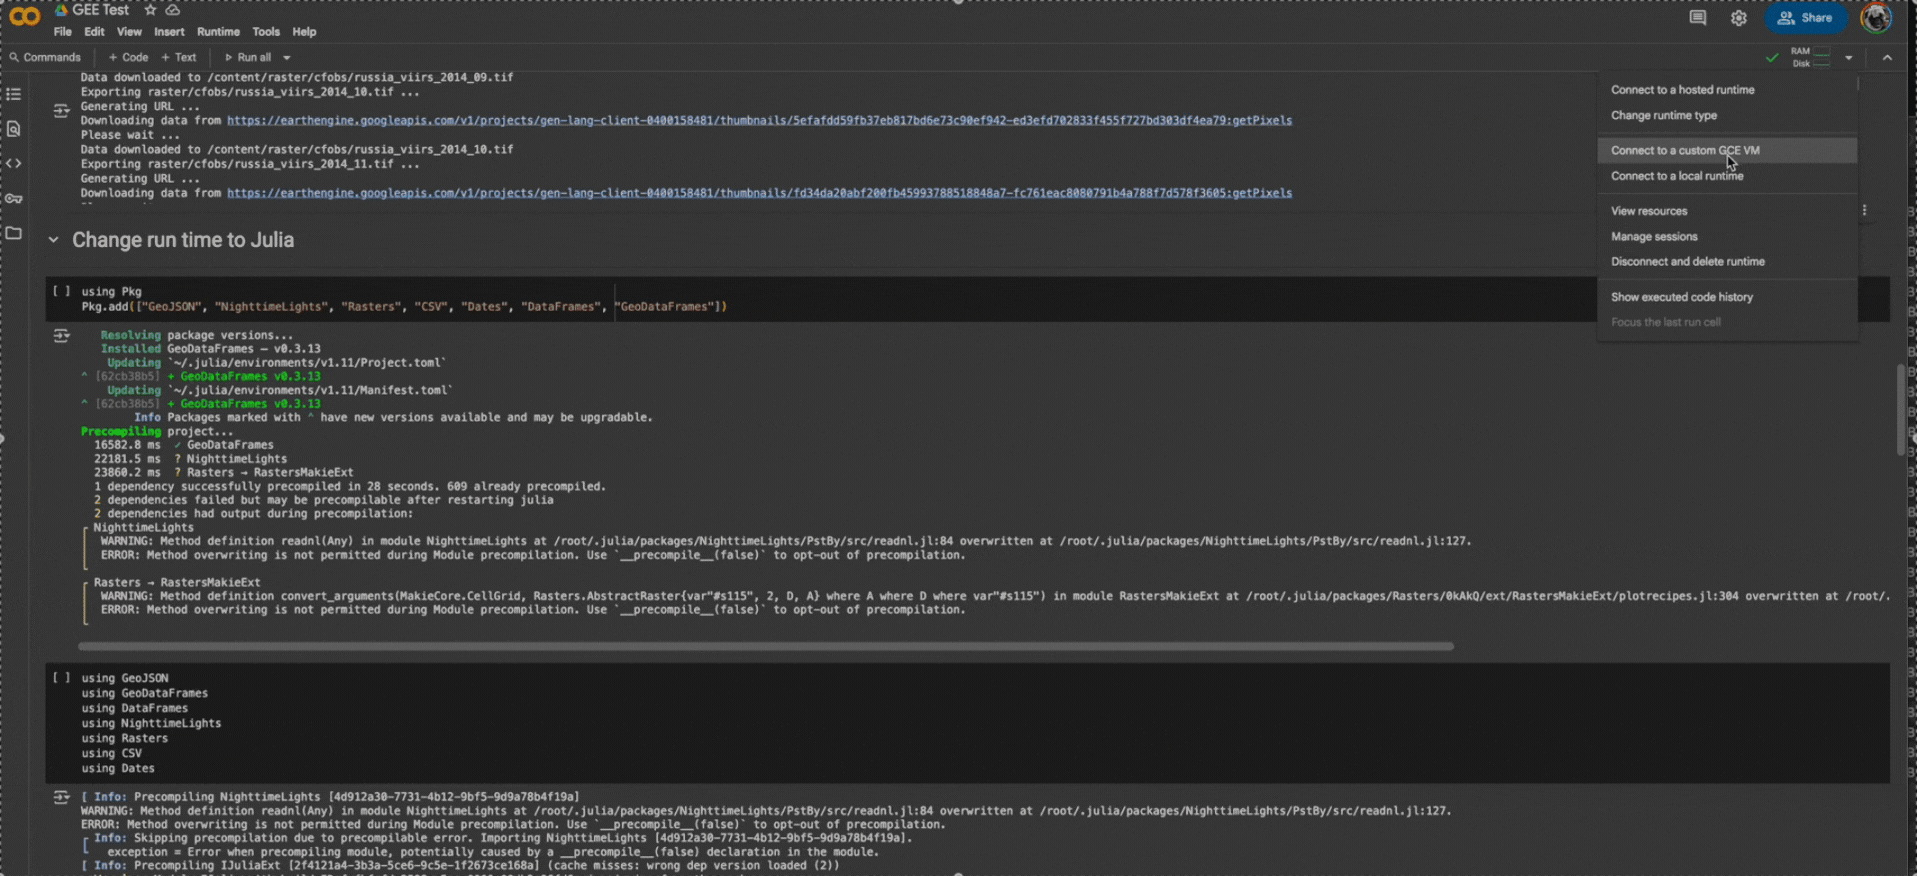

#Setup

##Get Assets

We fetch all the Julia packages required for the analysis

In [ ]:
using Pkg
Pkg.add(["GeoJSON", "NighttimeLights", "Rasters", "CSV", "Dates", "DataFrames","GeoDataFrames","GeometryBasics","ColorSchemes","Shapefile", "GeoInterface"]) #, "GeoDataFrames","AlgebraOfGraphics", "CairoMakie","GeometryBasics"

In [ ]:
;git clone https://github.com/xKDR/Shedding-light-on-the-Russia-Ukraine-war.git

In [ ]:
# ## Fetching the raster files
# ## This will take around 5 mins

# run(`apt-get install git-lfs -y`)
# run(`git lfs install`)
# cd("Shedding-light-on-the-Russia-Ukraine-war")
# run(`git lfs pull`)

In [ ]:
using GeoJSON
using GeoDataFrames
using GeometryBasics
using DataFrames
using NighttimeLights
using Rasters
using CSV
using Dates
using Shapefile

In [ ]:
# # Define path constants
# const FIGURES_DIRECTORY = "figures"
# const TABLES_DIRECTORY = "tables"
# const VECTOR_DIRECTORY = "data/vector"
# const TABULAR_DIRECTORY = "data/tabular"
# const RADIANCE_RASTER_DIRECTORY = "/content/Shedding-light-on-the-Russia-Ukraine-war/data/raster/rad_cropped"
# const CFOBS_RASTER_DIRECTORY = "/content/Shedding-light-on-the-Russia-Ukraine-war/data/raster/cf_cropped"

In [ ]:
# Define Local Paths
const FIGURES_DIRECTORY = "figures"
const TABLES_DIRECTORY = "tables"
const VECTOR_DIRECTORY = "data/vector"
const TABULAR_DIRECTORY = "data/tabular"
const RADIANCE_RASTER_DIRECTORY = "/content/raster/radiance"
const CFOBS_RASTER_DIRECTORY = "/content/raster/cfobs"

In [ ]:
const START_DATE = Date(2023, 1)
const END_DATE = Date(2025, 1)

##Functions

We define all processing and plotting functions here

###Processing

In [ ]:
function safe_centre_of_mass(slice::AbstractArray, state_name::String)
    s = sum(skipmissing(slice))
    if ismissing(s) || isnan(s) || s == 0.0f0
        return [NaN, NaN]
    end
    try
        return NighttimeLights.centre_of_mass(slice)
    catch e
        if isa(e, InexactError)
            println("Warning: CoM calculation failed for '$state_name'. Returning [NaN, NaN].")
            return [NaN, NaN]
        else
            rethrow(e)
        end
    end
end

In [ ]:

function read_shapefile(filepath::String)
    return DataFrame(Shapefile.Table(filepath))
end


In [ ]:
import Base.Filesystem: basename

function file_to_date(f::AbstractString)
    b = basename(f)
    m_ymd = match(r"\d{4}-\d{2}-\d{2}(?:T\d{2}:\d{2}:\d{2})?", b)
    m_ym = match(r"\d{4}_\d{2}", b)

    if m_ymd !== nothing
        s = m_ymd.match
        if occursin('T', s)
            return Date(DateTime(s, dateformat"yyyy-mm-ddTHH:MM:SS"))
        else
            return Date(s, dateformat"yyyy-mm-dd")
        end
    elseif m_ym !== nothing
        s = m_ym.match
        return Date(s, dateformat"yyyy_mm")
    else
        error("Cannot parse date from filename: $f")
    end
end


function read_region_as_datacubes(region; start_date::Date, end_date::Date,
    radiance_path, cf_path)

    rad_all = sort(joinpath.(radiance_path, filter(f -> endswith(f, ".tif"), readdir(radiance_path))))
    cf_all  = sort(joinpath.(cf_path, filter(f -> endswith(f, ".tif"), readdir(cf_path))))



    rad_inwin = filter(rad_all) do f
        try
            d = file_to_date(f)
            return start_date <= d <= end_date
        catch
            return false
        end
    end

    cf_inwin = filter(cf_all) do f
        try
            d = file_to_date(f)
            return start_date <= d <= end_date
        catch
            return false
        end
    end


    rad_inwin = rad_inwin[sortperm(file_to_date.(rad_inwin))]
    cf_inwin  = cf_inwin[sortperm(file_to_date.(cf_inwin))]

    rad_rasters = [Rasters.read(crop(Raster(f; lazy=true), to=region)) for f in rad_inwin]
    cf_rasters  = [Rasters.read(crop(Raster(f; lazy=true), to=region)) for f in cf_inwin]


    rad_series = RasterSeries(rad_rasters, Ti(file_to_date.(rad_inwin)))
    cf_series  = RasterSeries(cf_rasters,  Ti(file_to_date.(cf_inwin)))

    rad_datacube = Rasters.combine(rad_series, Ti)
    cf_datacube  = Rasters.combine(cf_series, Ti)
    return rad_datacube, cf_datacube
end


In [ ]:

function process_state(state_row::DataFrameRow)
    state_name = state_row.NAME_1
    state_geometry = state_row.geometry
    @show state_name

    radiance, cfobs = read_region_as_datacubes(state_geometry;
        start_date=START_DATE, end_date=END_DATE,
        radiance_path=RADIANCE_RASTER_DIRECTORY,
        cf_path=CFOBS_RASTER_DIRECTORY)


    print("file read correctly")

    try
        println("\nRadiance dimensions: ", dims(radiance))

        println("Attempting to calculate extent...")
        rad_extent = extent(radiance)
        println("Extent calculated successfully. Type: ", typeof(rad_extent))
        println("Radiance extent: ", rad_extent)

        println("Attempting to clean data...")
        radiance = clean_complete(radiance, cfobs; bgthreshold=4)
        cfobs = nothing
        println("Data cleaned successfully.")

        radiance = Raster(Float32.(radiance); missingval=missing)
        radiance[radiance .> 100.0f0] .= 0.0f0

        println("Attempting to mask raster...")
        radiance = mask(radiance; with=state_geometry)
        println("Masking successful.")

        dates = Date.(dims(radiance, Ti).val)
        num_timesteps = length(dates)

        if num_timesteps == 0
            println("Warning: No valid data for '$state_name' after cleaning and masking.")
            return DataFrame()
        end

        agg_radiance = [sum(skipmissing(view(radiance, Ti(i)))) for i in 1:num_timesteps]
        com = [safe_centre_of_mass(view(radiance, Ti(i)), state_name) for i in 1:num_timesteps]

        return DataFrame(; dates, aggregate_radiance=agg_radiance, com, state_name)

    catch e
        println("\nERROR occurred during processing of '$state_name'.")
        println("Error message: ", e)
        return DataFrame()
    end
end


In [ ]:
const a_WGS84 = 6378137.0
const inv_f_WGS84 = 298.257223563
const f_WGS84 = 1.0 / inv_f_WGS84
const e_sq_WGS84 = 2 * f_WGS84 - f_WGS84^2
const e_WGS84 = sqrt(e_sq_WGS84)
const lat1_proj_deg = 50.0
const lat2_proj_deg = 70.0
const latO_proj_deg = 40.0
const lonO_proj_deg = 100.0
const EF_proj = 0.0
const NF_proj = 0.0

function geodetic_to_albers_easting_northing(lat_deg::Float64, lon_deg::Float64)
    function _calculate_alpha_value(phi_rad::Float64, e_val::Float64, e_sq_val::Float64)
        sin_phi = sin(phi_rad)
        term1_den = 1.0 - e_sq_val * sin_phi^2
        term1 = sin_phi / term1_den
        log_arg_num = 1.0 - e_val * sin_phi
        log_arg_den = 1.0 + e_val * sin_phi
        term2_log = log(log_arg_num / log_arg_den)
        term2 = (1.0 / (2.0 * e_val)) * term2_log
        return (1.0 - e_sq_val) * (term1 - term2)
    end

    lat_rad, lon_rad = deg2rad(lat_deg), deg2rad(lon_deg)
    lat1_rad, lat2_rad = deg2rad(lat1_proj_deg), deg2rad(lat2_proj_deg)
    latO_rad, lonO_rad = deg2rad(latO_proj_deg), deg2rad(lonO_proj_deg)

    m1 = cos(lat1_rad) / sqrt(1.0 - e_sq_WGS84 * sin(lat1_rad)^2)
    m2 = cos(lat2_rad) / sqrt(1.0 - e_sq_WGS84 * sin(lat2_rad)^2)

    alpha = _calculate_alpha_value(lat_rad, e_WGS84, e_sq_WGS84)
    alphaO = _calculate_alpha_value(latO_rad, e_WGS84, e_sq_WGS84)
    alpha1 = _calculate_alpha_value(lat1_rad, e_WGS84, e_sq_WGS84)
    alpha2 = _calculate_alpha_value(lat2_rad, e_WGS84, e_sq_WGS84)

    n_val = (m1^2 - m2^2) / (alpha2 - alpha1)
    C_val = m1^2 + n_val * alpha1

    term_rho_sqrt = max(0.0, C_val - n_val * alpha)
    rho = (a_WGS84 * sqrt(term_rho_sqrt)) / n_val

    term_rhoO_sqrt = max(0.0, C_val - n_val * alphaO)
    rhoO = (a_WGS84 * sqrt(term_rhoO_sqrt)) / n_val

    theta = n_val * (lon_rad - lonO_rad)

    easting = EF_proj + rho * sin(theta)
    northing = NF_proj + rhoO - rho * cos(theta)

    return easting, northing
end


function overall_com(gdf, shp, radiance)
    russia_cropped = crop(radiance; to = shp.geometry)
    temp = zeros(size(russia_cropped))

    for i in 1:nrow(gdf)
        if occursin("_cross", gdf[i,:].state_name)
            continue
        end
        lon, lat = gdf[i,:].com
        val = gdf[i,:].aggregate_radiance

        x_idx = DimensionalData.dims2indices(dims(russia_cropped)[1], X(Near(lon)))
        y_idx = DimensionalData.dims2indices(dims(russia_cropped)[2], Y(Near(lat)))
        temp[x_idx, y_idx] += val
    end
    russia_raster_final = Raster(temp, dims(russia_cropped))
    return centre_of_mass(russia_raster_final)
end


In [ ]:

function process_group(gdf::SubDataFrame, shp_df::DataFrame)
    current_date = first(gdf.dates)
    year_month = Dates.format(current_date, "yyyy_mm")
    radiance_path = "/content/raster/radiance/radiance_$(year_month).tif"
    radiance = Raster(radiance_path, lazy=true)
    com_lon, com_lat = overall_com(gdf, shp_df, radiance)
    easting, northing = geodetic_to_albers_easting_northing(com_lat, com_lon)
    return (date=current_date, lon=com_lon, lat=com_lat, easting=easting, northing=northing)
end

###Plotting

In [ ]:
using DataFrames, Dates, Plots, Statistics, GeometryBasics, GeoInterface, Shapefile
gr(show=false)
default(fontfamily="Computer Modern")


function process_geometries(df::DataFrame; ignored_states::Set{String}=Set{String}())
    poly_list = []
    for row in eachrow(df)
        if (hasproperty(row, :NAME_1) && (row.NAME_1 == "Chukot" || row.NAME_1 in ignored_states))
            continue
        end

        geometry = row.geometry
        polygons_to_process = GeoInterface.trait(geometry) isa GeoInterface.PolygonTrait ? [geometry] : GeoInterface.getpolygon(geometry)
        for poly in polygons_to_process
            exterior_ring = GeoInterface.getexterior(poly)
            points = [Point2f(GeoInterface.x(p), GeoInterface.y(p)) for p in GeoInterface.getpoint(exterior_ring)]
            push!(poly_list, (geometry = Polygon(points), GID_0 = get(row, :GID_0, "")))
        end
    end
    return DataFrame(poly_list)
end


function create_com_trajectory_plot(map_df::DataFrame, com_df::DataFrame, start_year::Int, end_year::Int; is_projected::Bool, title::String, country_code::String)
    xlab = is_projected ? "Eastings" : "Longitude"
    ylab = is_projected ? "Northings" : "Latitude"

    p = plot(title=title, framestyle=:box, legend=:topleft, size=(1200, 600),
             margin=10Plots.mm, titlefontsize=16, xlabel=xlab, ylabel=ylab)

    all_lons, all_lats, main_lons, main_lats, other_lons, other_lats = (Float64[] for _ in 1:6)
    country_points = Dict{String, Vector{Point2f}}()

    for row in eachrow(map_df)
        points_ls = row.geometry.exterior
        iterable_points = GeoInterface.getpoint(points_ls)
        lons = [GeoInterface.x(pt) for pt in iterable_points]; lats = [GeoInterface.y(pt) for pt in iterable_points]
        append!(all_lons, lons); append!(all_lats, lats)

        if !isempty(country_code) && row.GID_0 == country_code
            append!(main_lons, lons); push!(main_lons, NaN); append!(main_lats, lats); push!(main_lats, NaN)
        else
            append!(other_lons, lons); push!(other_lons, NaN); append!(other_lats, lats); push!(other_lats, NaN)
            if !isempty(country_code)
                get!(country_points, row.GID_0, Point2f[])
                append!(country_points[row.GID_0], (Point2f(GeoInterface.x(p), GeoInterface.y(p)) for p in iterable_points))
            end
        end
    end

    plot!(p, other_lons, other_lats, seriestype=:shape, label="", fillcolor=:gray, linecolor=:darkgray, linewidth=0.5)
    plot!(p, main_lons, main_lats, seriestype=:shape, label="Main Country", fillcolor=:transparent, linecolor=:black, linewidth=0.7)

    country_annotations = [(code, mean(first.(pts)), mean(last.(pts))) for (code, pts) in country_points if !isempty(pts)]
    if !isempty(country_annotations)
        ann_lons=[a[2] for a in country_annotations]; ann_lats=[a[3] for a in country_annotations]; ann_texts=[text(a[1],:black,:center,10) for a in country_annotations]
        annotate!(p, ann_lons, ann_lats, ann_texts)
    end

    if !isempty(all_lons)
        min_lon, max_lon = extrema(all_lons); pad_lon = (max_lon - min_lon) * 0.05
        min_lat, max_lat = extrema(all_lats); pad_lat = (max_lat - min_lat) * 0.05
        xlims!(p, min_lon - pad_lon, max_lon + pad_lon); ylims!(p, min_lat - pad_lat, max_lat + pad_lat)
    end

    if !isempty(com_df)
        date_mask = start_year .<= year.(com_df.date) .<= end_year
        plot_com_df = com_df[date_mask, :]

        if isempty(plot_com_df)
            @warn "No COM data found for the period $start_year-$end_year."
        else
            sort!(plot_com_df, :date)
            if is_projected
                projected_coords = geodetic_to_albers_easting_northing.(plot_com_df.lat, plot_com_df.lon)
                plot_com_df.lon = first.(projected_coords); plot_com_df.lat = last.(projected_coords)
            end
            plot!(p, plot_com_df.lon, plot_com_df.lat, linecolor=:black, linewidth=1.5, linestyle=:dash, label="COM Trajectory", arrow=:arrow)
            start_point, end_point = first(plot_com_df), last(plot_com_df)
            scatter!(p, [start_point.lon], [start_point.lat], markercolor=:blue, markersize=5, markerstrokewidth=1, markerstrokecolor=:black, label="Start ($(year(start_point.date)))")
            scatter!(p, [end_point.lon], [end_point.lat], markercolor=:red, markersize=5, markerstrokewidth=1, markerstrokecolor=:black, label="End ($(year(end_point.date)))")
        end
    end

    return p
end


function generate_trajectory_map(
    shapefile_path::String,
    com_df::DataFrame,
    start_year::Int,
    end_year::Int;
    is_projected::Bool,
    title::String="Nightlight COM Trajectory",
    country_code::String="",
    ignored_states::Set{String}=Set{String}()
)
    map_data_raw = DataFrame(Shapefile.Table(shapefile_path))
    map_df = process_geometries(map_data_raw, ignored_states=ignored_states)

    final_plot = create_com_trajectory_plot(
        map_df,
        com_df,
        start_year,
        end_year;
        is_projected=is_projected,
        title="$title ($start_year-$end_year)",
        country_code=country_code
    )

    return final_plot
end

In [ ]:
using DataFrames, Dates, Plots, Statistics
gr(show=false)
default(fontfamily="Computer Modern")


function create_january_radiance_plot(
    agg_rad_df::DataFrame,
    plot_title_prefix::String,
    plot_color,
    start_year::Int,
    end_year::Int
)
    start_date = Date(start_year, 1, 1)
    end_date = Date(end_year, 12, 31)
    date_mask = start_date .<= agg_rad_df.dates .<= end_date
    filtered_rad_df = agg_rad_df[date_mask, :]

    monthly_total_radiance = DataFrames.combine(groupby(filtered_rad_df, :dates),
                                     :aggregate_radiance => sum => :total_radiance)
    sort!(monthly_total_radiance, :dates)

    january_radiance_df = filter(row -> month(row.dates) == 1, monthly_total_radiance)

    if isempty(january_radiance_df)
        @warn "No January data found between $start_year and $end_year."
        return plot(title=plot_title_prefix, size=(1200, 600))
    end

    year_labels = Dates.format.(january_radiance_df.dates, "yyyy")
    plot_title = "$plot_title_prefix ($start_year-$end_year)"

    p = plot(january_radiance_df.dates, january_radiance_df.total_radiance,
        label="Aggregate Radiance", color=plot_color, lw=2,
        ylabel="Radiance (nW/cm^2/sr)", xlabel="Year",
        title=plot_title, legend=:topleft, legendfontsize=14,
        tickfontsize=12, guidefontsize=14, titlefontsize=16,
        grid=true, size=(1200, 600), margin=10Plots.mm,
        framestyle=:box, xticks=(january_radiance_df.dates, year_labels)
    )

    war_start_date = Date(2022, 2, 24)
    if start_date <= war_start_date <= end_date
        vline!(p, [war_start_date],
               label="Start of Full-Scale Invasion", color=:black,
               linestyle=:dash, lw=1.5)
    end

    return p
end

In [ ]:
using DataFrames, Dates, Plots, Statistics
gr(show=false)
default(fontfamily="Computer Modern")

function create_full_timeseries_plot(
    agg_rad_df::DataFrame,
    plot_title_prefix::String,
    plot_color,
    start_year::Int,
    end_year::Int
)

    date_mask = start_year .<= year.(agg_rad_df.dates) .<= end_year
    filtered_rad_df = agg_rad_df[date_mask, :]

    if isempty(filtered_rad_df)
        @warn "No data found between $start_year and $end_year."
        return plot(title=plot_title_prefix, size=(1200, 600))
    end


    monthly_total_radiance = DataFrames.combine(groupby(filtered_rad_df, :dates),
                                     :aggregate_radiance => sum => :total_radiance)
    sort!(monthly_total_radiance, :dates)

    date_ticks = floor(minimum(monthly_total_radiance.dates), Year):Year(1):ceil(maximum(monthly_total_radiance.dates), Year)
    date_labels = Dates.format.(date_ticks, "yyyy")
    plot_title = "$plot_title_prefix ($start_year-$end_year)"

    p = plot(monthly_total_radiance.dates, monthly_total_radiance.total_radiance,
        label="Monthly Aggregate Radiance", color=plot_color, lw=2,
        ylabel="Radiance (nW/cm^2/sr)", xlabel="Year",
        title=plot_title, legend=:topleft, legendfontsize=14,
        tickfontsize=12, guidefontsize=14, titlefontsize=16,
        grid=true, size=(1200, 600), margin=10Plots.mm,
        framestyle=:box, xticks=(date_ticks, date_labels)
    )

    war_start_date = Date(2022, 2, 24)
    if Date(start_year) <= war_start_date <= Date(end_year, 12, 31)
        vline!(p, [war_start_date],
               label="Start of Full-Scale Invasion", color=:black,
               linestyle=:dash, lw=1.5)
    end

    return p
end

In [ ]:
using DataFrames, Dates, Plots, Statistics, Shapefile, ColorSchemes, GeometryBasics, GeoInterface
gr(show=false)
default(fontfamily="Computer Modern")


function calculate_state_growth(df::DataFrame, start_year::Int, start_month::Int, end_year::Int, end_month::Int)
    date_mask = map(d -> (year(d) == start_year && month(d) == start_month) ||
                           (year(d) == end_year && month(d) == end_month),
                    df.dates)
    filtered_df = df[date_mask, :]
    isempty(filtered_df) && return DataFrame()
    results = []
    for state_group in groupby(filtered_df, :state_name)
        state_name = first(state_group.state_name)
        start_row = filter(row -> year(row.dates) == start_year, state_group)
        end_row = filter(row -> year(row.dates) == end_year, state_group)
        if !isempty(start_row) && !isempty(end_row)
            start_value = first(start_row.aggregate_radiance)
            end_value = first(end_row.aggregate_radiance)
            if start_value > 0
                growth_rate = (end_value - start_value) / start_value * 100
                push!(results, (state_name=state_name, growth_rate=growth_rate))
            end
        end
    end
    return DataFrame(results)
end

function create_choropleth_map(
    agg_rad_df::DataFrame,
    shapefile_path::String,
    plot_title_prefix::String,
    start_year::Int,
    end_year::Int;
    is_projected::Bool,
    country_code_main::String,
    ignored_states::Set{String}=Set{String}(),
    selected_states::Set{String}=Set{String}(),
    skip_region::String=""
)

    map_data_raw = DataFrame(Shapefile.Table(shapefile_path))
    poly_list = []
    for row in eachrow(map_data_raw)
        (hasproperty(row, :NAME_1) && row.NAME_1 == skip_region && !isempty(skip_region)) && continue
        geometry = row.geometry
        polygons_to_process = GeoInterface.trait(geometry) isa GeoInterface.PolygonTrait ? [geometry] : GeoInterface.getpolygon(geometry)
        for poly in polygons_to_process
            exterior_ring = GeoInterface.getexterior(poly)
            points = [Point2f(GeoInterface.x(p), GeoInterface.y(p)) for p in GeoInterface.getpoint(exterior_ring)]
            push!(poly_list, (geometry=Polygon(points), GID_0=get(row, :GID_0, ""), NAME_1=get(row, :NAME_1, "")))
        end
    end
    map_df = DataFrame(poly_list)

    rad_df_subset = !isempty(selected_states) ? filter(r -> r.state_name in selected_states, agg_rad_df) : agg_rad_df
    map_df_subset = !isempty(selected_states) ? filter(r -> r.NAME_1 in selected_states, map_df) : map_df

    filtered_rad_df = isempty(ignored_states) ? rad_df_subset : filter(r -> !(r.state_name in ignored_states), rad_df_subset)
    filtered_map_df = isempty(ignored_states) ? map_df_subset : filter(r -> !(r.NAME_1 in ignored_states), map_df_subset)

    growth_df = calculate_state_growth(filtered_rad_df, start_year, 1, end_year, 1)
    growth_dict = Dict(row.state_name => row.growth_rate for row in eachrow(growth_df))


    xlab = is_projected ? "Eastings" : "Longitude"; ylab = is_projected ? "Northings" : "Latitude"
    plot_title = "$plot_title_prefix (Jan $start_year vs Jan $end_year)"

    p = plot(title=plot_title, titlefontsize=16, framestyle=:box, legend=:none, size=(1200, 700),
             margin=10Plots.mm, =300, xlabel=xlab, ylabel=ylab)

    min_g, max_g = -50.0, 50.0
    plot!(p, [NaN], [NaN], zcolor=range(min_g, max_g, length=100), clims=(min_g, max_g),
          seriescolor=:RdYlGn, colorbar=true, colorbar_title="\nGrowth Rate (%)", markersize=0, label="")

    shapes_by_color = Dict{String, Vector{Tuple{Vector{Float64}, Vector{Float64}}}}()
    other_lons, other_lats = Float64[], Float64[]
    for row in eachrow(filtered_map_df)
        points = row.geometry.exterior
        lons = [GeoInterface.x(pt) for pt in GeoInterface.getpoint(points)]; lats = [GeoInterface.y(pt) for pt in GeoInterface.getpoint(points)]
        if row.GID_0 == country_code_main
            growth = get(growth_dict, row.NAME_1, NaN)
            color = isnan(growth) ? "#E0E0E0" : "#" * hex(get(ColorSchemes.RdYlGn, (clamp(growth, min_g, max_g) - min_g) / (max_g - min_g)))
            get!(shapes_by_color, color, [])
            push!(shapes_by_color[color], (lons, lats))
        else
            append!(other_lons, lons); push!(other_lons, NaN); append!(other_lats, lats); push!(other_lats, NaN)
        end
    end

    !isempty(other_lons) && plot!(p, other_lons, other_lats, seriestype=:shape, fillcolor=:gray, linecolor=:white, linewidth=0.5, label="")
    for (color, shapes) in shapes_by_color
        all_lons, all_lats = Float64[], Float64[]
        for (lons, lats) in shapes
            append!(all_lons, lons); push!(all_lons, NaN); append!(all_lats, lats); push!(all_lats, NaN)
        end
        plot!(p, all_lons, all_lats, seriestype=:shape, fillcolor=color, linecolor=:white, linewidth=0.5, label="")
    end

    return p
end

In [ ]:
using DataFrames, Dates, Plots, Statistics, Shapefile, ColorSchemes, GeometryBasics, GeoInterface
gr(show=false)
default(fontfamily="Computer Modern")


function calculate_state_growth_between_months(df::DataFrame, start_y::Int, start_m::Int, end_y::Int, end_m::Int)
    date_mask = (Dates.year.(df.dates) .== start_y .& Dates.month.(df.dates) .== start_m) .|
                (Dates.year.(df.dates) .== end_y .& Dates.month.(df.dates) .== end_m)
    filtered_df = df[date_mask, :]
    isempty(filtered_df) && return DataFrame(state_name=String[], growth_rate=Float64[])
    return DataFrames.combine(groupby(filtered_df, :state_name)) do group
        start_row = filter(row -> Dates.year(row.dates) == start_y, group)
        end_row = filter(row -> Dates.year(row.dates) == end_y, group)
        if isempty(start_row) || isempty(end_row)
            return (growth_rate = NaN,)
        end
        start_val = first(start_row.aggregate_radiance)
        end_val = first(end_row.aggregate_radiance)
        growth = (start_val > 0) ? (end_val - start_val) / start_val * 100 : NaN
        return (growth_rate = growth,)
    end
end

function get_base_state_name(s_name::Union{String, Missing})
    if ismissing(s_name) || s_name == "" return "" end
    if occursin(r"^(Chukot|Чукот)"i, s_name) return "Chukotka" end
    return replace(replace(s_name, r"\d+$" => ""), r"_cross$" => "")
end


function create_growth_difference_choropleth_map(
    rad_df::DataFrame,
    shapefile_path::String,
    plot_title::String,
    p1_start_year::Int, p1_end_year::Int,
    p2_start_year::Int, p2_end_year::Int;
    is_projected::Bool,
    country_code_main::String,
    ignored_states::Set{String}=Set{String}(),
    selected_states::Set{String}=Set{String}(),
    skip_region::String=""
)

    function calculate_and_aggregate_growth(input_df, start_y, start_m, end_y, end_m, period_label)
        raw_growth = calculate_state_growth_between_months(input_df, start_y, start_m, end_y, end_m)
        raw_growth.base_state_name = get_base_state_name.(raw_growth.state_name)
        valid_growth = filter(row -> !ismissing(row.growth_rate) && !isnan(row.growth_rate), raw_growth)
        if isempty(valid_growth)
             all_names = DataFrame(base_state_name=unique(raw_growth.base_state_name)); all_names[!, period_label] .= NaN
             return all_names
        end
        agg_df = DataFrames.combine(groupby(valid_growth, :base_state_name), :growth_rate => mean => period_label)
        return leftjoin(DataFrame(base_state_name=unique(raw_growth.base_state_name)), agg_df, on=:base_state_name)
    end


    rad_df_subset = !isempty(selected_states) ? filter(r -> get_base_state_name(r.state_name) in selected_states, rad_df) : rad_df
    rad_df_filtered = isempty(ignored_states) ? rad_df_subset : filter(r -> !(get_base_state_name(r.state_name) in ignored_states), rad_df_subset)


    period1_growth = calculate_and_aggregate_growth(rad_df_filtered, p1_start_year, 1, p1_end_year, 1, :period1_growth)
    period2_growth = calculate_and_aggregate_growth(rad_df_filtered, p2_start_year, 1, p2_end_year, 1, :period2_growth)

    growth_diff_df = outerjoin(period1_growth, period2_growth, on=:base_state_name)
    growth_diff_df.growth_difference = growth_diff_df.period2_growth .- growth_diff_df.period1_growth


    map_data_raw = DataFrame(Shapefile.Table(shapefile_path))
    poly_list = []
    for row in eachrow(map_data_raw)
        name_1 = get(row, :NAME_1, "")
        base_name = get_base_state_name(name_1)
        if (!isempty(skip_region) && name_1 == skip_region) || (base_name in ignored_states) ||
           (!isempty(selected_states) && !(base_name in selected_states))
            continue
        end
        geometry = row.geometry
        polygons = GeoInterface.trait(geometry) isa GeoInterface.PolygonTrait ? [geometry] : GeoInterface.getpolygon(geometry)
        for poly in polygons
            points = [Point2f(GeoInterface.x(p), GeoInterface.y(p)) for p in GeoInterface.getpoint(GeoInterface.getexterior(poly))]
            push!(poly_list, (geometry=Polygon(points), GID_0=get(row, :GID_0, ""), NAME_1=name_1))
        end
    end
    map_df = DataFrame(poly_list)


    growth_dict = Dict(row.base_state_name => row.growth_difference for row in eachrow(growth_diff_df) if !ismissing(row.base_state_name))
    xlab = is_projected ? "Eastings" : "Longitude"; ylab = is_projected ? "Northings" : "Latitude"
    p = plot(title=plot_title, titlefontsize=16, legend=:none, framestyle=:box, size=(1200, 700),
             margin=10Plots.mm, dpi=300, xlabel=xlab, ylabel=ylab)
    valid_rates = filter(x -> !ismissing(x) && !isnan(x), collect(values(growth_dict)))
    max_abs_rate = isempty(valid_rates) ? 50.0 : max(50.0, max(abs.(extrema(valid_rates))...))
    min_g, max_g = -max_abs_rate, max_abs_rate
    plot!(p, [NaN], [NaN], zcolor=range(min_g, max_g, length=100), clims=(min_g, max_g), seriescolor=:RdYlGn,
          colorbar=true, colorbar_title="\nGrowth Rate Difference (%)", markersize=0, label="")

    shapes_by_color = Dict{String, Vector{Tuple{Vector{Float64}, Vector{Float64}}}}()
    for row in eachrow(map_df)
        points = row.geometry.exterior
        xs = [GeoInterface.x(pt) for pt in GeoInterface.getpoint(points)]; ys = [GeoInterface.y(pt) for pt in GeoInterface.getpoint(points)]
        base_name = get_base_state_name(row.NAME_1)
        growth = get(growth_dict, base_name, NaN)
        color = (ismissing(growth) || isnan(growth)) ? "#E0E0E0" : "#" * hex(get(ColorSchemes.RdYlGn, (clamp(growth, min_g, max_g) - min_g) / (max_g - min_g)))
        get!(shapes_by_color, color, [])
        push!(shapes_by_color[color], (xs, ys))
    end

    for (color, shapes) in shapes_by_color
        all_xs, all_ys = Float64[], Float64[]
        for (xs, ys) in shapes
            append!(all_xs, xs); push!(all_xs, NaN); append!(all_ys, ys); push!(all_ys, NaN)
        end
        plot!(p, all_xs, all_ys, seriestype=:shape, fillcolor=color, linecolor=:white, linewidth=0.5, label="")
    end

    return p
end

#ANALYSIS

##Russia

We process NTL data for Russia

### Radiance

In [ ]:
russia_state_split = read_shapefile("/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/russia_shapefile/split_states2.shp")

In [ ]:
radiance, cfobs = read_region_as_datacubes(
    russia_state_split.geometry[1];
    start_date=START_DATE,
    end_date=END_DATE,
    radiance_path=RADIANCE_RASTER_DIRECTORY,
    cf_path=CFOBS_RASTER_DIRECTORY
)

In [ ]:
radiance, cfobs = read_region_as_datacubes(russia_state_split[1, :].geometry;
    start_date=START_DATE, end_date=END_DATE,
    radiance_path=RADIANCE_RASTER_DIRECTORY,
    cf_path=CFOBS_RASTER_DIRECTORY)

In [ ]:
russia_agg_rad = DataFrame()

for i in 1:nrow(russia_state_split)
    state_row = russia_state_split[i, :]
    state_name = state_row.NAME_1
    println("--- Processing state $i/$(nrow(russia_state_split)): $state_name ---")

    try
        state_df = process_state(state_row)
        if !isempty(state_df)
            append!(russia_agg_rad, state_df; cols=:union)
        end
    catch e
        println("ERROR: Failed to process state '$state_name'. Skipping. Error: $e")
    end
    GC.gc()
end

println("--- Processing Complete ---")

# Final aggregation
if !isempty(russia_agg_rad)
    println("Aggregating results...")
    grouped = groupby(russia_agg_rad, :dates)
    aggregate_df = DataFrames.combine(grouped, :aggregate_radiance => sum => :AggregateRadiance)
    sort!(aggregate_df, :dates)

    # only write once if you want
    # CSV.write(AGGREGATE_FILE, aggregate_df)
    println("Aggregation complete, DataFrame in memory.")
else
    println("No data processed, skipping aggregation.")
end

println("Script finished.")


In [ ]:
russia_agg_rad

### COM

In [ ]:
using DataFrames, Dates, Rasters, Shapefile

shapefile_path = "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/russia_shapefile/split_states2.shp"
shp = DataFrame(Shapefile.Table(shapefile_path))

target_month = 1
filtered_data = filter(row -> month(row.dates) == target_month, russia_agg_rad)

if isempty(filtered_data)
    @warn "No data found for month: $(target_month)."
end

results = [process_group(gdf, shp) for gdf in groupby(filtered_data, :dates)]

rus_com = DataFrame(results)
sort!(rus_com, :date)

println(rus_com)

##Ukraine

We process NTL data for Ukraine (non disputed regions)

###Radiance

In [ ]:
ukraine_state_split = read_shapefile("/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp")

In [ ]:
const IGNORED_STATES = Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
ukraine_state_split = filter(row -> !(row.NAME_1 in IGNORED_STATES), ukraine_state_split)

In [ ]:
radiance, cfobs = read_region_as_datacubes(
    ukraine_state_split.geometry[1];
    start_date=START_DATE,
    end_date=END_DATE,
    radiance_path=RADIANCE_RASTER_DIRECTORY,
    cf_path=CFOBS_RASTER_DIRECTORY
)

In [ ]:
radiance, cfobs = read_region_as_datacubes(ukraine_state_split[1, :].geometry;
    start_date=START_DATE, end_date=END_DATE,
    radiance_path=RADIANCE_RASTER_DIRECTORY,
    cf_path=CFOBS_RASTER_DIRECTORY)

In [ ]:
ukr_agg_rad = DataFrame()

for i in 1:nrow(ukraine_state_split)
    state_row = ukraine_state_split[i, :]
    state_name = state_row.NAME_1
    println("--- Processing state $i/$(nrow(ukraine_state_split)): $state_name ---")

    try
        state_df = process_state(state_row)
        if !isempty(state_df)
            append!(ukr_agg_rad, state_df; cols=:union)
        end
    catch e
        println("ERROR: Failed to process state '$state_name'. Skipping. Error: $e")
    end
    GC.gc()
end

println("--- Processing Complete ---")

# Final aggregation
if !isempty(ukr_agg_rad)
    println("Aggregating results...")
    grouped = groupby(ukr_agg_rad, :dates)
    aggregate_df = DataFrames.combine(grouped, :aggregate_radiance => sum => :AggregateRadiance)
    sort!(aggregate_df, :dates)

    # only write once if you want
    # CSV.write(AGGREGATE_FILE, aggregate_df)
    println("Aggregation complete, DataFrame in memory.")
else
    println("No data processed, skipping aggregation.")
end

println("Script finished.")


In [ ]:
ukr_agg_rad

### COM

In [ ]:
using DataFrames, Dates, Rasters, Shapefile

shapefile_path = "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp"
ukr_shp = DataFrame(Shapefile.Table(shapefile_path))

target_month = 1
ukr_filtered_data = filter(row -> month(row.dates) == target_month, ukr_agg_rad)

if isempty(ukr_filtered_data)
    @warn "No data found for month: $(target_month)."
end

results = [process_group(gdf, ukr_shp) for gdf in groupby(ukr_filtered_data, :dates)]

ukr_com = DataFrame(results)
sort!(ukr_com, :date)

println("--- Ukraine Center of Mass (Lon/Lat) for Month $(target_month) ---")
println(ukr_com)

##Disputed

We process NTL data for Disputed regions

In [ ]:
disp_state_split = read_shapefile("/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp")

In [ ]:
const IGNORED_STATES = Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
disp_state_split = subset(disp_state_split, :NAME_1 => ByRow(x -> x in IGNORED_STATES))

In [ ]:
radiance, cfobs = read_region_as_datacubes(
    disp_state_split.geometry[1];
    start_date=START_DATE,
    end_date=END_DATE,
    radiance_path=RADIANCE_RASTER_DIRECTORY,
    cf_path=CFOBS_RASTER_DIRECTORY
)

In [ ]:
radiance, cfobs = read_region_as_datacubes(disp_state_split[1, :].geometry;
    start_date=START_DATE, end_date=END_DATE,
    radiance_path=RADIANCE_RASTER_DIRECTORY,
    cf_path=CFOBS_RASTER_DIRECTORY)

In [ ]:
disp_agg_rad = DataFrame()

for i in 1:nrow(disp_state_split)
    state_row = disp_state_split[i, :]
    state_name = state_row.NAME_1
    println("--- Processing state $i/$(nrow(disp_state_split)): $state_name ---")

    try
        state_df = process_state(state_row)
        if !isempty(state_df)
            append!(disp_agg_rad, state_df; cols=:union)
        end
    catch e
        println("ERROR: Failed to process state '$state_name'. Skipping. Error: $e")
    end
    GC.gc()
end

println("--- Processing Complete ---")

# Final aggregation
if !isempty(disp_agg_rad)
    println("Aggregating results...")
    grouped = groupby(disp_agg_rad, :dates)
    aggregate_df = DataFrames.combine(grouped, :aggregate_radiance => sum => :AggregateRadiance)
    sort!(aggregate_df, :dates)

    # only write once if you want
    # CSV.write(AGGREGATE_FILE, aggregate_df)
    println("Aggregation complete, DataFrame in memory.")
else
    println("No data processed, skipping aggregation.")
end

println("Script finished.")


In [ ]:
disp_agg_rad

#Visualisations

This section shows the results of the processed NTL data

##Russia

###COM

In [ ]:
generate_trajectory_map(
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/russia_shapefile/russia_plus_neighbors_aea.shp",
    rus_com,
    2019, # Start Year
    2025; # End Year
    is_projected=true,
    title="Russia Nightlight COM Trajectory",
    country_code="RUS"
)


###Plots

In [ ]:
russia_plot = create_january_radiance_plot(
    russia_agg_rad,
    "Russia's Aggregate Nighttime Radiance in January",
    :red,
    2019,
    2025
)
display(russia_plot)

In [ ]:
russia_timeseries_plot = create_full_timeseries_plot(
    russia_agg_rad,
    "Russia's Aggregate Nighttime Radiance",
    :red,
    2019, # Start Year
    2025  # End Year
)
display(russia_timeseries_plot)

In [ ]:
russia_choropleth = create_choropleth_map(
    russia_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/russia_shapefile/russia_plus_neighbors_aea.shp",
    "Change in Nightlight Radiance in Russia",
    2019, # Start Year
    2022; # End Year
    is_projected=true,
    country_code_main="RUS",
    skip_region="Chukot"
)

In [ ]:
russia_choropleth = create_choropleth_map(
    russia_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/russia_shapefile/russia_plus_neighbors_aea.shp",
    "Change in Nightlight Radiance in Russia",
    2022, # Start Year
    2025; # End Year
    is_projected=true,
    country_code_main="RUS",
    skip_region="Chukot"
)

In [ ]:
russia_choropleth = create_choropleth_map(
    russia_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/russia_shapefile/russia_plus_neighbors_aea.shp",
    "Change in Nightlight Radiance in Russia",
    2019, # Start Year
    2025; # End Year
    is_projected=true,
    country_code_main="RUS",
    skip_region="Chukot"
)

In [ ]:
russia_annual_plots = create_annual_choropleth_maps(
    russia_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/russia_shapefile/russia_plus_neighbors_aea.shp",
    "Russia",
    [2019],
    is_projected=true,
    country_code_main="RUS",
)

display(russia_annual_plots[1])

In [ ]:
russia_annual_plots = create_annual_choropleth_maps(
    russia_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/russia_shapefile/russia_plus_neighbors_aea.shp",
    "Russia",
    [2025],
    is_projected=true,
    country_code_main="RUS",
)

display(russia_annual_plots[1])

In [ ]:
# Assumes `russia_agg_rad` DataFrame is already defined.
russia_growth_diff_plot = create_growth_difference_choropleth_map(
    russia_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/russia_shapefile/russia_plus_neighbors_aea.shp",
    "Change in Radiance Growth: Pre-War vs. Post-War",
    2019, 2022, # Period 1: Jan 2019 vs Jan 2022
    2022, 2025; # Period 2: Jan 2022 vs Jan 2025
    is_projected=true,
    country_code_main="RUS",
    skip_region="Chukot"
)

display(russia_growth_diff_plot)

##Ukraine

###COM

In [ ]:
generate_trajectory_map(
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp",
    ukr_com,
    2019, # Start Year
    2025; # End Year
    is_projected=false,
    title="Ukraine Nightlight COM Trajectory",
    country_code="UKR",
    ignored_states=Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
)

###Plots

In [ ]:

# 1. Generate and display the plot for Russia.
ukraine_plot = create_january_radiance_plot(
    ukr_agg_rad,
    "Ukraine's Aggregate Nighttime Radiance in January",
    :blue,
    2019,
    2025
)
display(ukraine_plot)


In [ ]:
ukraine_timeseries_plot = create_full_timeseries_plot(
    ukr_agg_rad,
    "Ukraine's Aggregate Nighttime Radiance",
    :blue,
    2019, # Start Year
    2025  # End Year
)
display(ukraine_timeseries_plot)

In [ ]:
ukraine_choropleth = create_choropleth_map(
    ukr_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp",
    "Change in Nightlight Radiance in Ukraine",
    2019, # Start Year
    2022; # End Year
    is_projected=false,
    country_code_main="UKR",
    ignored_states=Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
)

In [ ]:
ukraine_choropleth = create_choropleth_map(
    ukr_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp",
    "Change in Nightlight Radiance in Ukraine",
    2022, # Start Year
    2025; # End Year
    is_projected=false,
    country_code_main="UKR",
    ignored_states=Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
)

In [ ]:
ukraine_choropleth = create_choropleth_map(
    ukr_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp",
    "Change in Nightlight Radiance in Ukraine",
    2019, # Start Year
    2025; # End Year
    is_projected=false,
    country_code_main="UKR",
    ignored_states=Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
)

In [ ]:
ukraine_annual_plot = create_annual_choropleth_maps(
    ukr_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp",
    "Ukraine",
    [2019],
    is_projected=false,
    country_code_main="UKR",
    ignored_states=Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
)
display(ukraine_annual_plot[1])

In [ ]:
ukraine_annual_plot = create_annual_choropleth_maps(
    ukr_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp",
    "Ukraine",
    [2025],
    is_projected=false,
    country_code_main="UKR",
    ignored_states=Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
)
display(ukraine_annual_plot[1])

In [ ]:
# Assumes `ukr_agg_rad` DataFrame is already defined.
ukraine_growth_diff_plot = create_growth_difference_choropleth_map(
    ukr_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp",
    "Change in Radiance Growth: Pre-War vs. Post-War",
    2019, 2022, # Period 1: Jan 2019 vs Jan 2022
    2022, 2025; # Period 2: Jan 2022 vs Jan 2025
    is_projected=false,
    country_code_main="UKR",
    ignored_states=Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
)

# display(ukraine_growth_diff_plot)

##Disputed

In [ ]:
disp_plot = create_january_radiance_plot(
    disp_agg_rad,
    "Disputed Region's Aggregate Nighttime Radiance in January",
    :green,
    2019,
    2024
)
display(disp_plot)


In [ ]:
disputed_timeseries_plot = create_full_timeseries_plot(
    disp_agg_rad,
    "Disputed Region's Aggregate Nighttime Radiance",
    :green,
    2019, # Start Year
    2025  # End Year
)
display(disputed_timeseries_plot)

In [ ]:
disputed_choropleth = create_choropleth_map(
    disp_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp",
    "Change in Nightlight Radiance in Disputed Region",
    2019, # Start Year
    2022; # End Year
    is_projected=false,
    country_code_main="UKR",
    selected_states=Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
)

In [ ]:
disputed_choropleth = create_choropleth_map(
    disp_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp",
    "Change in Nightlight Radiance in Disputed Region",
    2022, # Start Year
    2025; # End Year
    is_projected=false,
    country_code_main="UKR",
    selected_states=Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
)

In [ ]:
disputed_choropleth = create_choropleth_map(
    disp_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp",
    "Change in Nightlight Radiance in Disputed Region",
    2019, # Start Year
    2025; # End Year
    is_projected=false,
    country_code_main="UKR",
    selected_states=Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
)

In [ ]:
disp_annual_plot = create_annual_choropleth_maps(
    disp_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp",
    "Disputed Region 2024",
    [2019],
    is_projected=false,
    country_code_main="UKR",
    selected_states=Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
)
display(disp_annual_plot[1])

In [ ]:
disp_annual_plot = create_annual_choropleth_maps(
    disp_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp",
    "Disputed Region 2024",
    [2025],
    is_projected=false,
    country_code_main="UKR",
    selected_states=Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
)
display(disp_annual_plot[1])

In [ ]:
disp_growth_diff_plot = create_growth_difference_choropleth_map(
    disp_agg_rad,
    "/content/Shedding-light-on-the-Russia-Ukraine-war/data/vector/ukraine_shapefile/gadm41_UKR_1.shp",
    "Change in Radiance Growth: Pre-War vs. Post-War",
    2019, 2022, # Period 1: Jan 2019 vs Jan 2022
    2022, 2025; # Period 2: Jan 2022 vs Jan 2025
    is_projected=false,
    country_code_main="UKR",
    selected_states=Set(["Donets'k", "Kherson", "Luhans'k", "Zaporizhia", "Crimea", "Sevastopol'"])
)

display(disp_growth_diff_plot)